**Name:** \_\_\_\_\_ Chan Tai To

**EID:** \_\_\_\_\_ 54791401

# CS4487 - Tutorial 8: Non-Linear Dimensionality Reduction and Face Recognition

In this tutorial you will use non-linear dimensionality reduction on face images, and then train a classifier for face recognition. 

First we need to initialize Python.  Run the below cell.

In [54]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
import joblib
from numpy import *
from sklearn import *
import glob
import os
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=FutureWarning)
random.seed(100)
rbow = plt.get_cmap('rainbow')

## Loading Data and Pre-processing
We first need to load the images.  We will use the same dataset as Tutorial 7. Download `olivetti_py3.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [2]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show all the images!

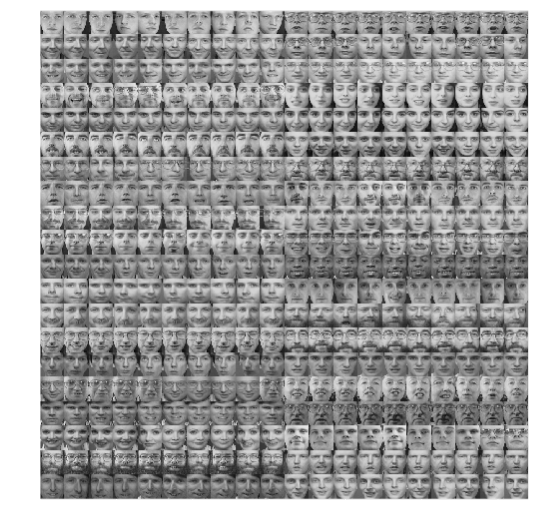

In [3]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. Now we split the data into training and testing sets.

In [4]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(320, 4096)
(80, 4096)


## Non-Linear Dimensionality Reduction - KPCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use KPCA to reduce the dimension first and then use the KPCA weights as the representation for each image.  Run KPCA on the data using **10** principal components.  Use the RBF kernel with gamma=0.001.

In [8]:
### INSERT YOUR CODE HERE
## HINT
# 1. decomposition.KernelPCA(n_components= , kernel= , gamma= , n_jobs= )
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001, n_jobs=-1)

In [9]:
### INSERT YOUR CODE HERE
new_trainX = kpca.fit_transform(trainX)
new_testX = kpca.fit_transform(testX)

The below function will plot the basis vectors of KPCA. Run the next 2 cells to view the PCs.  The kernel PCs are a combination of similarities to points in the training set.  The PCs are visualized by showing the top 5 positive and negative training examples, along with their coefficient $\alpha_i$.

In [10]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.alphas_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("{:.3f}".format(alphas[i,jj]), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

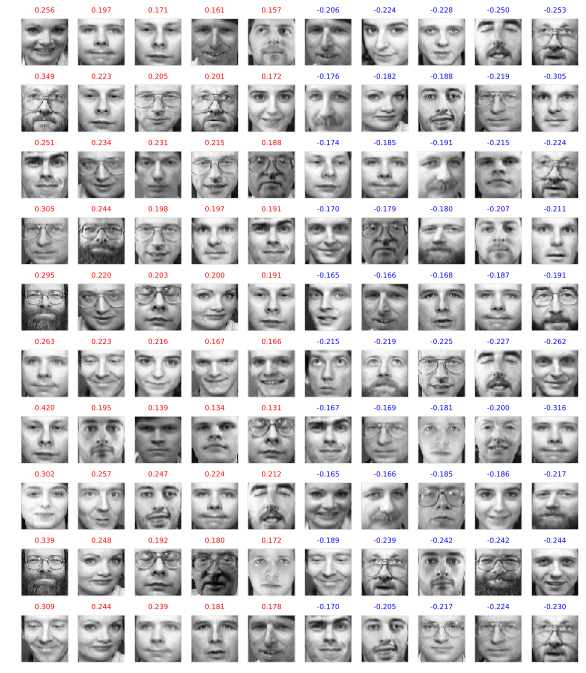

In [13]:
# run the function
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

_What is the interpretation for the KPCA basis?  What kind of faces do some of the PCs prefer?_
- **INSERT YOUR ANSWER HERE**

### Face Recognition
Now train a logistic classifier to do the face recognition.  Use the calculated KPCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components or kernel hyperparameters.  Calculate the average training and testing accuracies.  Remember to transform the test data into the KPCA representation too!


In [16]:
cs = logspace(-4, 4, 20)

In [17]:
### INSERT YOUR CODE HERE
## HINT 
# 1. linear_model.LogisticRegressionCV(Cs= , cv= , n_jobs= )
# 2. acc = metrics.accuracy_score( , )
lrcv = linear_model.LogisticRegressionCV(Cs=cs, cv=5, n_jobs=-1)
lrcv.fit(new_trainX, trainY)
predict = lrcv.predict(new_testX)

In [19]:
### INSERT YOUR CODE HERE
acc = metrics.accuracy_score(predict, testY)
print(f"The accuracy of KPCA is {acc}")

The accuracy of KPCA is 0.1


## Non-Linear Dimensionality Reduction - ICA

Next, we will use ICA to reduce the dimension.

- Applying the ICA with **20** principal components as the representation for each image. 
- Using the calculated ICA representation to  train a logistic classifier to do the face recognitio. 
- Calculating the average training and testing accuracies. 

In [18]:
### INSERT YOUR CODE HERE
## HINT
# 1. decomposition.FastICA(n_components=  )
# 2. linear_model.LogisticRegressionCV(Cs= , cv= , n_jobs= )
ica = decomposition.FastICA(n_components=20)
ilrcv = linear_model.LogisticRegressionCV(Cs=cs, cv=5, n_jobs=-1)
ilrcv.fit(new_trainX, trainY)
i_predict = ilrcv.predict(new_testX)

In [20]:
### INSERT YOUR CODE HERE
i_acc = metrics.accuracy_score(i_predict, testY)
print(f"The accuracy of FastICA is {i_acc}")

The accuracy of FastICA is 0.1


## Finding the best kernel and best number of components
Now try different kernels (poly, RBF), kernel parameters, and number of components to get the best test accuracy using KPCA.  
Train a logistic classifier for each one and see which dimension gives the best testing accuracy. 
Make a plots of number of components vs. test accuracy.

In [76]:
gammas = [0.0001, 0.0005, 0.001, 0.005, 0.01]
ncs = [5, 10, 15, 20, 25, 30]
degrees = [1, 2, 3, 4, 5]
nc = max(ncs)

lg = len(gammas)
ln = len(ncs)
ld = len(degrees)

In [45]:
## HINT
#1. KernelPCA(n_components=nc, kernel='rbf', gamma=, n_jobs=)
#2. LogisticRegressionCV(Cs=, cv=, n_jobs=)
#3. metrics.accuracy_score( , )

trainacc_rbf = zeros((lg, ln))
testacc_rbf = zeros((lg, ln))
### INSERT YOUR CODE HERE ###
print("RBF Kernel\ngammas, ns: train score, test score")
for i in range(lg):
    for j in range(ln):
        nc = ncs[j]
        ga = gammas[i]
        # Fit & transform
        rbf_kpca = decomposition.KernelPCA(n_components=nc, kernel='rbf', gamma=ga, n_jobs=-1)
        rbf_trainX = rbf_kpca.fit_transform(trainX)
        rbf_testX = rbf_kpca.fit_transform(testX)
        
        # Train a model
        rbf_cv = linear_model.LogisticRegressionCV(Cs=cs, cv=5, n_jobs=-1, multi_class='auto', max_iter=1000)
        rbf_cv.fit(rbf_trainX, trainY)

        # Predict and score
        train_predict = rbf_cv.predict(rbf_trainX)
        train_score = metrics.accuracy_score(train_predict, trainY)
        trainacc_rbf[i][j] = train_score

        test_predict = rbf_cv.predict(rbf_testX)
        test_score = metrics.accuracy_score(test_predict, testY)
        testacc_rbf[i][j] = test_score

        print(f"{ga}, {nc} : {train_score}, {test_score}")


RBF Kernel
gammas, ns: train score, test score
0.0001, 5 : 0.8125, 0.0625
0.0001, 10 : 0.975, 0.0125
0.0001, 15 : 1.0, 0.0125
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
0.0001, 20 : 1.0, 0.0125
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
0.0001, 25 : 1.0, 0.0125
0.0001, 30 : 1.0, 0.0125
0.0005, 5 : 0.83125, 0.1125
0.0005, 10 : 0.98125, 0.0375
0.0005, 15 : 1.0, 0.05
0.0005, 20 : 1.0, 0.075
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
0.0005, 25 : 1.0, 0.075
0.0005, 30 : 1.0, 0.075
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
0.001, 5 : 0.85625, 0.125
0

In [46]:
print(trainacc_rbf)
print(testacc_rbf)

[[0.8125   0.975    1.       1.       1.       1.      ]
 [0.83125  0.98125  1.       1.       1.       1.      ]
 [0.85625  0.98125  1.       1.       1.       1.      ]
 [0.828125 0.96875  1.       1.       1.       1.      ]
 [0.79375  0.996875 0.996875 1.       1.       1.      ]]
[[0.0625 0.0125 0.0125 0.0125 0.0125 0.0125]
 [0.1125 0.0375 0.05   0.075  0.075  0.075 ]
 [0.125  0.125  0.1    0.075  0.05   0.0625]
 [0.0625 0.0125 0.025  0.025  0.0375 0.05  ]
 [0.1625 0.1    0.0625 0.025  0.05   0.0625]]


In [47]:
## HINT
#1. KernelPCA(n_components=nc, kernel='poly', degree=, n_jobs=)
#2. LogisticRegressionCV(Cs=, cv=, n_jobs=)
#3. metrics.accuracy_score( , )

trainacc_poly = zeros((ld, ln))
testacc_poly  = zeros((ld, ln))
### INSERT YOUR CODE HERE ###
print("Poly Kernel\ndegree, ns: train score, test score")
for i in range(ld):
    for j in range(ln):
        nc = ncs[j]
        de = degrees[i]
        # Fit & transform
        poly_kpca = decomposition.KernelPCA(n_components=nc, kernel='poly', degree=de, n_jobs=-1)
        poly_trainX = poly_kpca.fit_transform(trainX)
        poly_testX = poly_kpca.fit_transform(testX)
        
        # Train a model
        poly_cv = linear_model.LogisticRegressionCV(Cs=cs, cv=5, n_jobs=-1, multi_class='auto', max_iter=1000)
        poly_cv.fit(poly_trainX, trainY)

        # Predict and score
        train_predict = poly_cv.predict(poly_trainX)
        train_score = metrics.accuracy_score(train_predict, trainY)
        trainacc_poly[i][j] = train_score

        test_predict = poly_cv.predict(poly_testX)
        test_score = metrics.accuracy_score(test_predict, testY)
        testacc_poly[i][j] = test_score

        print(f"{de}, {nc} : {train_score}, {test_score}")


Poly Kernel
degree, ns: train score, test score
1, 5 : 0.80625, 0.0625
1, 10 : 0.975, 0.0
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
1, 15 : 1.0, 0.0125
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
1, 20 : 1.0, 0.0125
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
1, 25 : 1.0, 0.0125
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
1, 30 : 1.0, 0.0125
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
2, 5 : 0.825, 0.125
2, 10 : 0.978125, 0.0875
C:\Program

In [48]:
print(trainacc_poly)
print(testacc_poly)

[[0.80625  0.975    1.       1.       1.       1.      ]
 [0.825    0.978125 1.       1.       1.       1.      ]
 [0.825    0.975    1.       1.       1.       1.      ]
 [0.83125  0.98125  1.       1.       1.       1.      ]
 [0.8375   1.       1.       1.       1.       1.      ]]
[[0.0625 0.     0.0125 0.0125 0.0125 0.0125]
 [0.125  0.0875 0.1    0.1    0.1    0.1   ]
 [0.0375 0.025  0.025  0.025  0.025  0.025 ]
 [0.15   0.0125 0.05   0.0125 0.025  0.0375]
 [0.175  0.05   0.0875 0.1    0.0625 0.0625]]


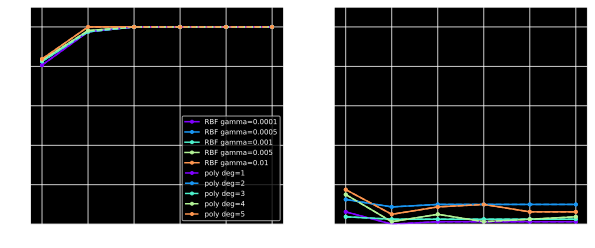

In [78]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for i, gamma in enumerate(gammas):
    plt.plot(ncs, trainacc[i,:], '.-', color=rbow(float(i)/len(gammas)), label="RBF gamma="+str(gamma))

for i, d in enumerate(degrees):
    plt.plot(ncs, trainacc_poly[i,:], '.--', color=rbow(float(i)/len(degrees)), label="poly deg="+str(d))
plt.ylim(0,1.1)    

plt.legend(loc="lower right", fontsize=7)
plt.grid(True)
plt.subplot(1,2,2)

for i, gamma in enumerate(gammas):
    plt.plot(ncs, testacc[i,:], '.-', color=rbow(float(i)/len(gammas)))

for i,d in enumerate(degrees):
    plt.plot(ncs, testacc_poly[i,:], '.--', color=rbow(float(i)/len(degrees)))

plt.ylim(0,1.1)
    
plt.grid(True)

In [75]:
rbf_best = max(map(max, testacc_rbf))
poly_best = max(map(max, testacc_poly))

poly_index = np.where(testacc_poly == poly_best)

print(f"rbf: {rbf_best}\npoly: {poly_best}")
print(f"The index is {poly_index}")

rbf: 0.1625
poly: 0.175
The index is (array([4], dtype=int64), array([0], dtype=int64))


_What is the best kernel and number of components?  View the prototypes for each compenent to see what they look like_
- **INSERT YOUR ANSWER HERE**

Ploy is the best kernel, degree is 5, n_components is 5.

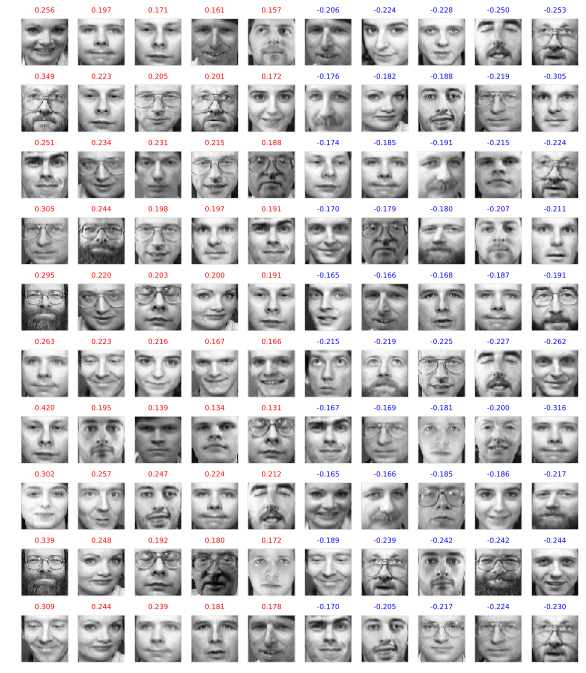

In [79]:
### INSERT YOUR CODE HERE
## HINT
# 1. ii = unravel_index(argmax(testacc), testacc.shape)
# 2. gamma = gammas[ii[0]]
# 3. plot_kbasis(kpca, imgsize, trainX)

ii = unravel_index(argmax(testacc_poly), testacc_poly.shape)
gamma = gammas[ii[0]]
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)
